In [34]:
import numpy as np
import matplotlib.pyplot as plt
import pandas
from IPython.display import display, Math

In [35]:
ns = 1.444
nf = 3.476
lambda0 = 1550e-9
pi = np.pi 
k0 = 2*pi/lambda0
c0 = 299792458
neff = 1.91
ng = 4.63
L = 20.3e-6
Cband = np.linspace(1.530e-6, 1.565e-6, 2000)
beta = (neff*2*pi)/Cband
band = np.linspace(1500e-9, 1600e-9, 2000)

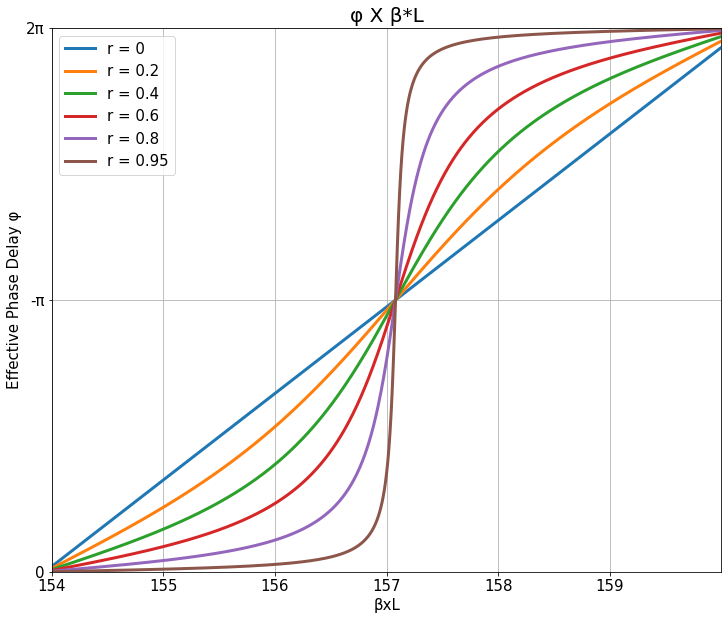

In [42]:
figure1 = plt.figure(figsize=(12, 10))
a = 1
r = [0, 0.2, 0.4, 0.6, 0.8, 0.95]
phi = beta*L

for i in range(0,len(r)):
    phase = pi + phi + np.arctan((r[i]*np.sin(phi))/(a-r[i]*np.cos(phi))) + np.arctan(a*r[i]*np.sin(phi)/(1-a*r[i]*np.cos(phi))) 
    plt.grid(True)
    plt.title('φ X β*L', size = 20)
    plt.ylabel('Effective Phase Delay φ', size = '15')
    plt.xlabel('βxL', size = '15')
    phase = phase%(2*pi)
    plt.xticks(np.arange(154,160, step = 1), size = '15')
    plt.xlim([154,160])
    plt.yticks([0, pi, 2*pi], ['0', '-π', '2π'], size = '15')
    plt.ylim([0,2*pi])
    plt.plot(phi, phase, label = 'r = ' + str(r[i]), linewidth = 3)
    plt.legend(loc = 'upper left', prop = {'size': 15})
    #plt.xlim([-pi,pi])
    #plt.xticks([-pi, -pi/2, 0, pi/2, pi], ['-π', '-π/2', '0', 'π/2', 'π'], size = '15')

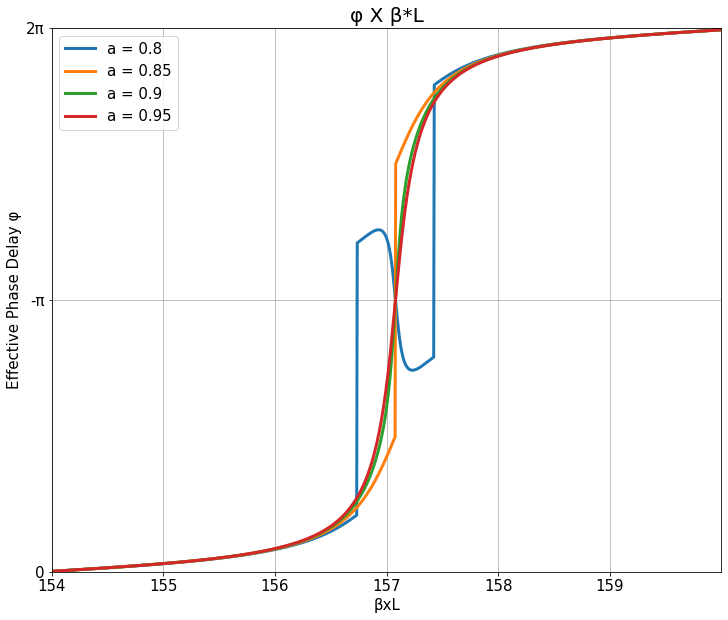

In [43]:
figure2 = plt.figure(figsize=(12, 10))
a = [0.8, 0.85, 0.9, 0.95]
r = 0.85
phi = beta*L

for i in range(0,len(a)):
    phase = pi + phi + np.arctan((r*np.sin(phi))/(a[i]-r*np.cos(phi))) + np.arctan((a[i]*r*np.sin(phi))/(1-(a[i]*r*np.cos(phi))))  
    plt.grid(True)
    plt.title('φ X β*L', size = 20)
    plt.ylabel('Effective Phase Delay φ', size = '15')
    plt.xlabel('βxL', size = '15')
    phase = phase%(2*pi)
    plt.xticks(np.arange(154,160, step = 1), size = '15')
    plt.xlim([154,160])
    plt.yticks([0, pi, 2*pi], ['0', '-π', '2π'], size = '15')
    plt.ylim([0,2*pi])
    plt.plot(phi, phase, label = 'a = ' + str(a[i]), linewidth = 3)
    plt.legend(loc = 'upper left', prop = {'size': 15})
    #plt.xlim([-pi,pi])
    #plt.xticks([-pi, -pi/2, 0, pi/2, pi], ['-π', '-π/2', '0', 'π/2', 'π'], size = '15')

FWHM = 0.9505 nm
Fsr = 2.56e-08
Theorical L = 20.3 μm
Theorical Q = 1630.7206733298265
Theorical Finesse = 31.95162267342691
K² = 0.0936


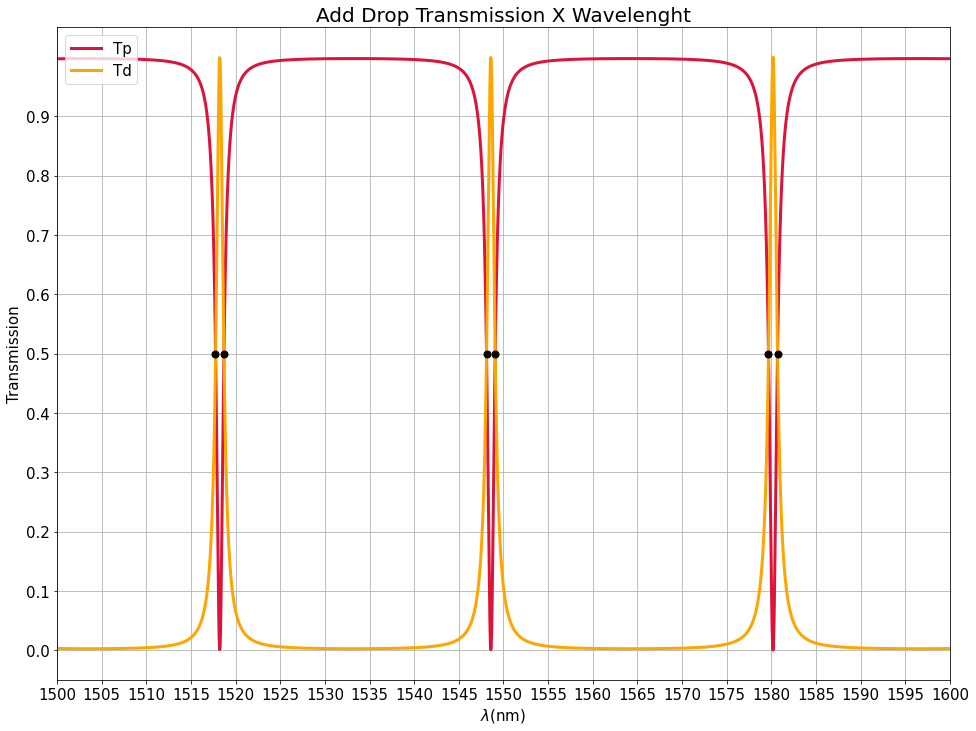

In [70]:
figure3 = plt.figure(figsize=(16, 12))

a = 1
Fsr = 25.6e-9
FWHM = 0.8e-9
neff = 1.91
r1 = 0.952046
r2 = 0.952046
band = np.linspace(1500e-9, 1600e-9,2000)
Cband = np.linspace(1.530e-6, 1.565e-6, 2000)

beta = (neff*2*pi)/band
L = (((1550e-9)**2)/(ng*Fsr))
k = round(1-r1*r2,4)

phi = 2*beta*L

Tp = ((r2**2)*(a**2) - (2*r1*r2*a*np.cos(phi)) + r1**2)/(1 - 2*r1*r2*a*np.cos(phi) + (r1*r2*a)**2)
Td = ((1-r1**2)*(1-r2**2)*a)/(1 - 2*r1*r2*a*np.cos(phi) + (r1*r2*a)**2)
Func = np.linspace(0.5 ,0.5, 2000)

Q = (pi*ng*L*(np.sqrt(r1*r2*a)))/(1550e-9*(1-r1*r2*a))
Finesse = (pi*(np.sqrt(r1*r2*a)))/(1 - r1*r2*a)

plt.plot(band*1e9, Tp, linewidth = "3", color = 'crimson', label = 'Tp')
plt.plot(band*1e9, Td, linewidth = "3", color = 'orange', label = 'Td')
plt.xlim(band[0]*1e9,band[-1]*1e9)
plt.ylabel("Transmission", fontsize = '15')
plt.xlabel(r'$\lambda$(nm)', fontsize = '15')
plt.xticks(np.arange(1500, 1605, step = 5), size = '15')
plt.yticks(np.arange(0, 1, step = 0.1), size = '15')
plt.legend(loc = 'upper left', prop = {'size': 15})
plt.grid()
plt.title('Add Drop Transmission X Wavelenght', size = '20')
idx = np.argwhere(np.diff(np.sign(Func - Tp)) != 0).reshape(-1) + 0
values = np.zeros(len(idx))
for i in range(len(idx)):
    plt.plot(((band[idx[i]]+band[idx[i]+1])/2.)*1e9,(Func[idx[i]]+Func[idx[i]+1])/2., marker = "o", markersize = 7, markeredgecolor = "black", markerfacecolor = 'black')
    values[i] = float(((band[idx[i]]+band[idx[i]+1])/2.)*1e9)
FWHM = round(values[3] - values[2], 4)
Q = (1550)/FWHM
print('FWHM = ' + str(FWHM) + ' nm')
print('Fsr = ' + str(Fsr))
print('Theorical L = ' + str(round(L*1e6,1)) + ' μm')
print('Theorical Q = '+ str(Q))
print('Theorical Finesse = '+ str(Finesse))
print('K² = ' + str(k))